## 7.6 畳み込みニューラルネットワークの実践

### 7.6.1 使用するデータセット

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

(1797, 64)


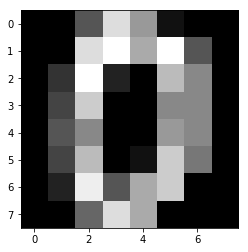

In [2]:
# 手書き文字データセットを読み込んで表示
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
import matplotlib.pyplot as plt 
from sklearn import datasets

digits = datasets.load_digits()
print(digits.data.shape)

plt.imshow(digits.data[0].reshape(8, 8), cmap="gray")
plt.show() 

In [3]:
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
print(digits.target.shape)
print(digits.target[:50])

(1797,)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0]


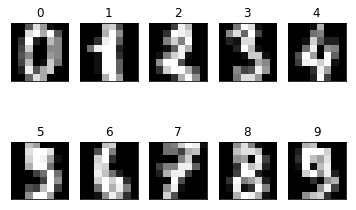

In [4]:
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
import matplotlib.pyplot as plt 
from sklearn import datasets

digits = datasets.load_digits()

fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off") 
    plt.imshow(digits.data[i].reshape(8, 8), cmap="gray")
    plt.title(digits.target[i])

plt.show() 

### 7.6.3 CNNのコード

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- 手書き文字データセットの読み込み --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

# -- 入力データの標準化 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

# -- 正解をone-hot表現に --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# -- 訓練データとテストデータ --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]  # 訓練 入力
correct_train = correct_data[index_train, :]  # 訓練 正解
input_test = input_data[index_test, :]  # テスト 入力
correct_test = correct_data[index_test, :]  # テスト 正解

n_train = input_train.shape[0]  # 訓練データのサンプル数
n_test = input_test.shape[0]  # テストデータのサンプル数

In [6]:
# 学習に関する各値を設定
# -- 各設定値 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
img_h = 8  # 入力画像の高さ
img_w = 8  # 入力画像の幅
img_ch = 1  # 入力画像のチャンネル数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 50
batch_size = 8
interval = 10  # 経過の表示間隔
n_sample = 200  # 誤差計測のサンプル数

In [7]:
# im2colとcol2imの関数を定義
# -- im2col --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
   
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

# -- col2im --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
 
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w, ).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]

    return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [8]:
# -- 畳み込み層 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
class ConvLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # n_flt:フィルタ数, flt_h:フィルタ高さ, flt_w:フィルタ幅
    # stride:ストライド幅, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # フィルタとバイアスの初期値
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 出力画像のサイズ
        self.y_ch = n_flt  # 出力チャンネル数
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 出力高さ
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  # 出力幅
 
        # AdaGrad用
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像とフィルタを行列に変換
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 出力の計算: 行列積、バイアスの加算、活性化関数
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # フィルタとバイアスの勾配
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # 入力の勾配
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- プーリング層 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
class PoolingLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # pool:プーリング領域のサイズ, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        # 出力画像のサイズ
        self.y_ch = x_ch  # 出力チャンネル数
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  # 出力高さ
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  # 出力幅
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像を行列に変換
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 出力の計算: Maxプーリング
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        # 最大値のインデックスを保存
        self.max_index = np.argmax(cols, axis=1)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 出力の勾配の軸を入れ替え
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # 行列を作成し、各列の最大値であった要素にのみ出力の勾配を入れる
        grad_cols = np.zeros((pool*pool, grad_y.size))
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1) 
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4) 
        grad_cols = grad_cols.reshape( y_ch*pool*pool, n_bt*y_h*y_w)

        # 入力の勾配
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

In [9]:
# 全結合層をクラスとして実装する
# -- 全結合層の継承元 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- 全結合 中間層 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 全結合 出力層 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

In [10]:
# -- 各層の初期化 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = MiddleLayer(n_fc_in, 100)
ol_1 = OutputLayer(100, 10)

# -- 順伝播 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
def forward_propagation(x):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    pl_1.forward(cl_1.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)   
    ml_1.forward(fc_input)
    ol_1.forward(ml_1.y)

# -- 逆伝播 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
def backpropagation(t):
    n_bt = t.shape[0]
    
    ol_1.backward(t)
    ml_1.backward(ol_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_1.backward(pl_1.grad_x)

# -- 重みとバイアスの更新 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
def uppdate_wb():
    cl_1.update(eta)
    ml_1.update(eta) # 畳み込み層の誤差を減少させる効果の検証を見る際にはコメントアウトする
    ol_1.update(eta) # 畳み込み層の誤差を減少させる効果の検証を見る際にはコメントアウトする

# -- 誤差を計算 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size # 交差エントロピー誤差

# -- サンプルを順伝播 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand) 
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t

In [11]:
# -- 誤差の記録用 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
n_batch = n_train // batch_size
for i in range(epoch):

    # -- 誤差の計測 -- 
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    
    x, t = forward_sample(input_test, correct_test, n_sample) 
    error_test = get_error(t, n_sample)
    
    # -- 誤差の記録 -- 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    
    # -- 経過の表示 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
    
    # -- 学習 -- 
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)   
    for j in range(n_batch):
        
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        forward_propagation(x)
        backpropagation(t)        
        uppdate_wb() 

Epoch:0/50 Error_train:2.3216217761270777 Error_test:2.3128534765843693
Epoch:10/50 Error_train:0.054754125577130816 Error_test:0.1027653943462603
Epoch:20/50 Error_train:0.03609057140867802 Error_test:0.07500187147274202
Epoch:30/50 Error_train:0.020443465694648295 Error_test:0.1067630815144366
Epoch:40/50 Error_train:0.01308046377160881 Error_test:0.1268666959300637


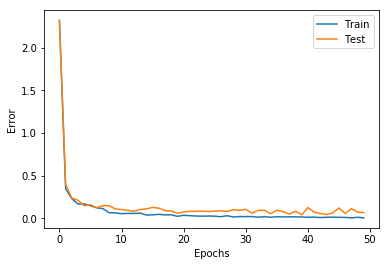

Accuracy Train: 99.91652754590984% Accuracy Test: 97.8297161936561%


In [12]:
# -- 誤差の記録をグラフ表示 -- 
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
#---+--10|----+--20|----+--30|----+--40|----+--50|----+--60|----+--70|----+--80|
x, t = forward_sample(input_train, correct_train, n_train) 
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test) 
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

In [13]:
samples = input_test[:5]
forward_propagation(samples)
print(ol_1.y)
print(correct_test[:5])

[[9.99996783e-01 6.65596913e-10 1.83623338e-08 3.62723117e-09
  1.02340070e-06 1.65812602e-06 9.12519223e-10 2.45713508e-07
  7.85659902e-08 1.87240329e-07]
 [4.27179828e-11 7.11207318e-08 6.20799152e-07 9.99910491e-01
  1.40303948e-10 1.44242124e-05 8.02502142e-11 5.84328658e-08
  2.68934162e-06 7.16448002e-05]
 [9.39644199e-08 1.45279330e-05 1.34906447e-07 8.30469021e-10
  2.50574480e-06 7.85283581e-09 9.99934609e-01 3.85233454e-11
  4.81198529e-05 1.97834112e-12]
 [7.41360824e-05 3.28454267e-05 4.87418133e-09 1.00407668e-04
  3.58220803e-04 1.16631115e-01 1.86496143e-09 4.08412100e-06
  4.30348437e-04 8.82368836e-01]
 [2.32841185e-09 2.69687155e-04 9.99365656e-01 3.02024163e-04
  3.02675477e-06 3.08227014e-06 1.13788379e-07 2.70112235e-06
  5.33296652e-05 3.77051346e-07]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
